In [19]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return round(size / 1024, 0)
    elif unit == "MB":
        return round(size / (1024 * 1024), 0)
    elif unit == "GB":
        round(size / (1024 * 1024 * 1024), 0)
    else:
        return size


In [20]:
import random
import json
from datetime import datetime
import sys

sys.path.append("..")

from app.models.spectrum_pb2 import Spectrum


def payload_spectrum_pb(num_data):
    """
    Generate UTF-8 payload of spectrum plot
    """
    d = []
    sd_u = []
    sd_l = []
    x_max = num_data
    y_min = 1
    y_max = 20

    for i in range(x_max):
        d.append(random.randrange(y_min, y_max - 1, 1))
        sd_u.append(0.4)
        sd_l.append(0.2)

    payload_pb = Spectrum(
        timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        x_min=0,
        x_max=x_max,
        y_min=y_min,
        y_max=y_max,
        data=d,
        sd_l=sd_l,
        sd_u=sd_u,
    )

    payload_ser = payload_pb.SerializeToString()
    return [payload_ser, sys.getsizeof(payload_ser)]


In [21]:
def payload_spectrum_utf(num_data):
    """
    Generate UTF-8 payload of spectrum plot
    Returns payload and its size
    """
    d = []
    sd_u = []
    sd_l = []
    x_max = num_data
    y_min = 1
    y_max = 20

    for i in range(x_max):
        d.append(random.randrange(y_min, y_max - 1, 1))
        sd_u.append(0.4)
        sd_l.append(0.4)

    payload_text = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "x_min": 0,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "data": d,
        "sd_l": sd_l,
        "sd_u": sd_u,
    }

    payload_ser = json.dumps(payload_text).encode("utf-8")
    return [payload_ser, sys.getsizeof(payload_ser)]


In [147]:
import matplotlib.pyplot as plt
import math

def plot_payload_size(x, y1, y2, unit="bytes"):
    """ """
    fig = plt.figure(figsize=(6, 3), tight_layout=True)
    ax = fig.gca()

    plt.plot(x, y1, "-", linewidth=2, color="tomato", label="UTF-8")
    plt.plot(x, y2, "-", linewidth=2, color="royalblue", label="ProtoBuf")

    # x, y labels
    plt.xlabel("frequency channels", fontsize=12)
    plt.ylabel(f"payload size (in {unit})", fontsize=12)

    # change x, y range to start from min and max data
    ax.set_xlim([x[0], x[-1]])
    ax.set_ylim([math.floor(min(y1[0], y2[0])), math.ceil(max(y1[-1], y2[-1]))])

    # tick labels font
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.tick_params(axis="both", which="minor", labelsize=12)

    # title
    # plt.title('Two or more lines on same plot with suitable legends ')

    # legend
    plt.legend(fontsize=12, loc="lower right")

    # grid
    plt.grid(linestyle="--", linewidth="1", color="black", alpha=0.2)

    # spines: https://matplotlib.org/stable/api/spines_api.html
    ax.spines["top"].set(
        visible=True, linestyle="--", linewidth="1", color="black", alpha=0.2
    )
    ax.spines["right"].set(
        visible=True, linestyle="--", linewidth="1", color="black", alpha=0.2
    )

    plt.show()


### Payload Size

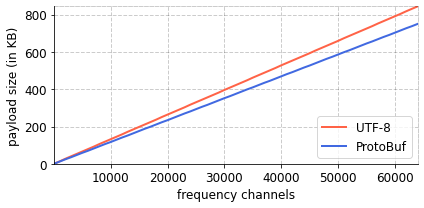

In [148]:
x = []
y1 = []
y2 = []
unit = "KB"

for i in range(1, 65000, 1000):
    x.append(i)
    y1.append(convert_bytes(payload_spectrum_utf(i)[1], unit))
    y2.append(convert_bytes(payload_spectrum_pb(i)[1], unit))

plot_payload_size(x, y1, y2, unit)


## Kafka

In [26]:
from aiokafka import AIOKafkaProducer

BROKER_INSTANCE = "localhost:9092"
MAX_REQ_SIZE = 15 * 1024 * 1024  # 15MB


async def produce(payload, topic):
    """
    input: serialized payload
    """
    aioproducer = AIOKafkaProducer(
        bootstrap_servers=BROKER_INSTANCE,
        compression_type="gzip",
        max_request_size=MAX_REQ_SIZE,
    )

    await aioproducer.start()
    res = await aioproducer.send_and_wait(topic, payload)
    print(f"produce: sent, response = {res}")

    return


In [61]:
from time import sleep

size = 40000

for i in range(1, 10, 1):
    [payload_pb, _] = payload_spectrum_pb(size)
    await produce(payload_pb, "spectrum-pb")
    #sleep(1)

Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3005216a0>
Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc300703340>


produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=141, timestamp=1644331131209, timestamp_type=0)
produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=142, timestamp=1644331131387, timestamp_type=0)


Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3004fa670>
Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc300469c10>
Task was destroyed but it is pending!
task: <Task pending name='Task-1246' coro=<Sender._sender_routine() running at /home/saifulkhan/CODE/SKA/streaming-vis-perf/broker/venv/lib/python3.8/site-packages/aiokafka/producer/sender.py:147> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fc3004fac10>()]> cb=[Sender._fail_all()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-1256' coro=<Sender._sender_routine() running at /home/saifulkhan/CODE/SKA/streaming-vis-perf/broker/venv/lib/python3.8/site-packages/aiokafka/producer/sender.py:147> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fc3004693a0>()]> cb=[Sender._fail_all()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-1266' coro=<Sender._sender_routin

produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=143, timestamp=1644331131558, timestamp_type=0)
produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=144, timestamp=1644331131732, timestamp_type=0)


Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc300469c10>
Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3003f55e0>


produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=145, timestamp=1644331131902, timestamp_type=0)
produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=146, timestamp=1644331132071, timestamp_type=0)


Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3003f55e0>
Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3003f55e0>


produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=147, timestamp=1644331132243, timestamp_type=0)
produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=148, timestamp=1644331132425, timestamp_type=0)


Unclosed AIOKafkaProducer
producer: <aiokafka.producer.producer.AIOKafkaProducer object at 0x7fc3003f55e0>


produce: sent, response = RecordMetadata(topic='spectrum-pb', partition=0, topic_partition=TopicPartition(topic='spectrum-pb', partition=0), offset=149, timestamp=1644331132598, timestamp_type=0)


### Box Plot

In [153]:
import numpy as np

def plot_deserialisation_time(y, x=[]):
    """ """
    fig = plt.figure(figsize=(8, 4), tight_layout=True)
    ax = fig.gca()

    # plt.plot(x, y1, "-", linewidth=2, color="tomato", label="UTF-8")
    # plt.plot(x, y2, "-", linewidth=2, color="royalblue", label="ProtoBuf")

    # x, y labels
    plt.xlabel("frequency channels", fontsize=12)
    plt.ylabel(f"time (in ms)", fontsize=12)

    # change x, y range to start from min and max data
    # ax.set_xlim([x[0], x[-1]])
    # ax.set_ylim([math.floor(min(y1[0], y2[0])), math.ceil(max(y1[-1], y2[-1]))])

    # tick labels font
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.tick_params(axis="both", which="minor", labelsize=12)

    # title
    # plt.title('Two or more lines on same plot with suitable legends ')

    # legend
    # plt.legend(fontsize=12, loc="lower right")

    # grid
    plt.grid(linestyle="--", linewidth="1", color="black", alpha=0.2)

    # spines: https://matplotlib.org/stable/api/spines_api.html
    ax.spines["top"].set(
        visible=True, linestyle="--", linewidth="1", color="black", alpha=0.2
    )
    ax.spines["right"].set(
        visible=True, linestyle="--", linewidth="1", color="black", alpha=0.2
    )

    ax.boxplot(y, labels=x)

    plt.show()


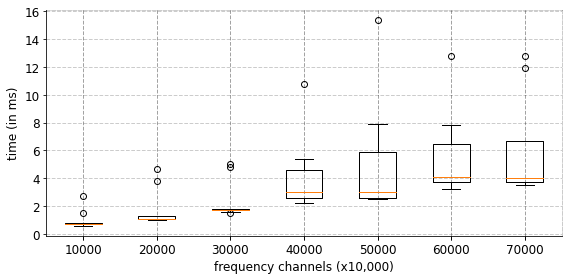

In [152]:

data_1 = [2.699999999254942, 1.5, 0.7000000011175871, 0.8000000007450581, 0.6000000014901161, 0.7999999988824129, 0.6999999992549419, 0.6999999992549419, 0.6999999992549419]
data_2 = [3.800000000745058, 4.699999999254942, 1.200000001117587, 1.299999998882413, 1.099999999627471, 1.099999999627471, 1.099999999627471, 1.099999999627471, 1]
data_3 = [4.800000000745058, 5, 1.700000001117587, 1.800000000745058, 1.6000000014901161, 1.700000001117587, 1.5, 1.699999999254942, 1.699999999254942]
data_4 = [10.800000000745058, 3, 5.400000000372529, 2.599999999627471, 3.300000000745058, 2.599999999627471, 4.600000001490116, 2.200000001117587, 2.900000000372529]
data_5 = [15.400000000372529, 7.900000000372529, 5.900000000372529, 2.5, 3.5, 2.599999999627471, 2.599999999627471, 2.899999998509884, 3]
data_6 = [12.799999998882413, 7.800000000745058, 6.5, 4.099999999627471, 3.199999999254942, 3.699999999254942, 3.5, 3.700000001117587, 4.400000000372529]
data_7 = [12.800000000745058, 11.900000000372529, 6.699999999254942, 3.699999999254942, 4, 3.599999999627471, 4.300000000745058, 3.5, 3.900000000372529]

y = [data_1, data_2, data_3, data_4, data_5, data_6, data_7]
x = [10000, 20000, 30000, 40000, 50000, 60000, 70000]

plot_deserialisation_time(y, x)

In [127]:
x = [39.30000000074506, 35, 35.59999999962747, 36.40000000037253, 38.09999999962747, 32, 30.300000000745058]